    # Imports 

In [8]:
from hydra import initialize, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf
import random
import torch
import pickle as pk, numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.fft import fft, fftfreq
from src.simulators.types import SimTime
from src.data_loader import data_preparation as dp
SEED = 17
random.seed(SEED)

In [9]:
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Systems visualization

In [10]:
def simulate_system(sys_name: str = 'duff'):
    with initialize(version_base=None, config_path="../baselines/config/system"):
        cfg = compose(config_name=sys_name)
        OmegaConf.resolve(cfg)
        cfg = cfg.data
    system = instantiate(cfg.system)
    solver = instantiate(cfg.solver)
    sim_time = instantiate(cfg.sim_time)
    sim_time.t0, sim_time.tn, sim_time.eps = -50,0,0.01
    simulated_data = dp.simulate_system_data(system, solver, sim_time)
    return simulated_data

In [62]:
# %%capture
sys_names = ['duff', 'rossler', 'chua', 'lorenz', 'sir', 'vdp']
data =[ simulate_system(sys_name)[0] for sys_name in sys_names]

5000it [00:00, 7979.60it/s]
5000it [00:00, 6918.82it/s]
5000it [00:00, 7458.01it/s]
5000it [00:00, 9414.11it/s]
5000it [00:00, 7861.07it/s]
5000it [00:00, 8108.02it/s]
5000it [00:00, 8014.94it/s]
5000it [00:00, 7109.49it/s]
5000it [00:00, 8226.93it/s]
5000it [00:00, 8319.31it/s]
5000it [00:00, 7578.23it/s]
5000it [00:00, 7895.39it/s]
5000it [00:00, 10843.40it/s]
5000it [00:00, 19807.19it/s]
5000it [00:00, 8054.02it/s]
5000it [00:00, 13965.31it/s]
5000it [00:00, 19034.51it/s]
5000it [00:00, 15525.55it/s]
5000it [00:00, 9611.38it/s]
5000it [00:00, 9879.02it/s] 
5000it [00:00, 18510.38it/s]
5000it [00:00, 15723.07it/s]
5000it [00:00, 8925.86it/s] 
5000it [00:00, 6348.96it/s] 
5000it [00:00, 11801.58it/s]
5000it [00:00, 9487.87it/s] 
5000it [00:00, 13042.53it/s]
5000it [00:00, 7434.10it/s] 
5000it [00:00, 11535.08it/s]
5000it [00:00, 5768.93it/s]
5000it [00:00, 13659.67it/s]
5000it [00:00, 7889.39it/s] 
5000it [00:00, 11072.04it/s]
5000it [00:00, 9593.62it/s] 
5000it [00:00, 18914.66it/s]


In [72]:
 with initialize(version_base=None, config_path="../baselines/config/system"):
        cfg = compose(config_name='duff')
        OmegaConf.resolve(cfg)

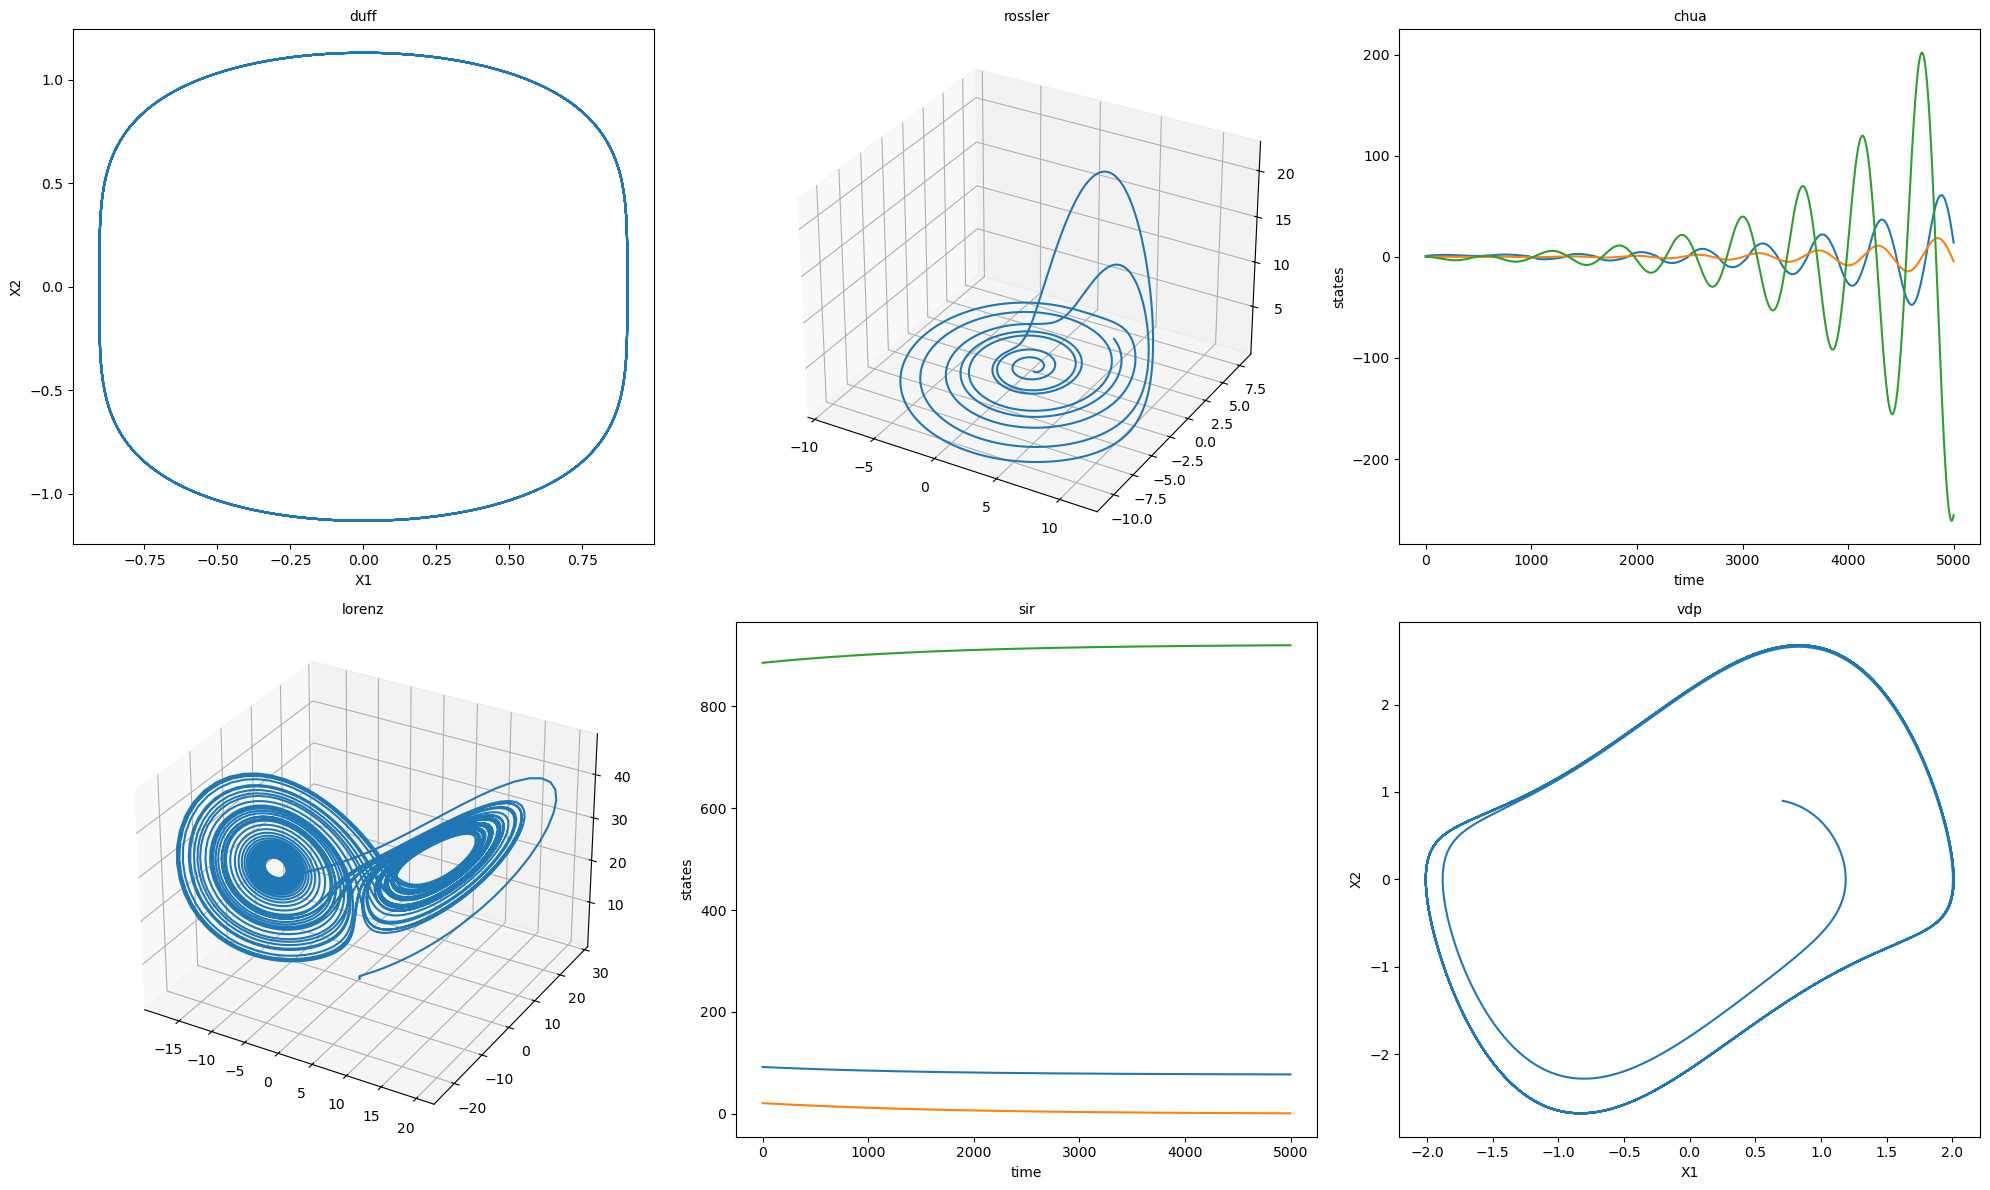

In [63]:
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
idx = 5 # change the initial condition system
# Flatten the 2D array of axes for easier Iteration
axs = axs.flatten()
for i, (x, class_name) in enumerate(zip(data, sys_names)):
    x =np.squeeze(x, 0) # input dimension 
    if x.shape[2] == 3:  # Check if the last dimension is 3 for a 3D plot
        if class_name in ['sir', 'chua']:
            axs[i].plot(x[idx, :, 0])
            axs[i].plot(x[idx, :, 1])
            axs[i].plot(x[idx, :, 2])
            axs[i].set_xlabel('time')
            axs[i].set_ylabel('states') 
        else:
            axs[i].axis('off')
            ax = fig.add_subplot(2, 3, i + 1, projection='3d')
            ax.plot(x[idx, :, 0], x[idx, :, 1], x[idx, :, 2])
    elif x.shape[2] == 2:  # Check if the last dimension is 2 for a 2D plot
        axs[i].plot(x[idx, :, 0], x[idx, :, 1])
        axs[i].set_xlabel('X1')
        axs[i].set_ylabel('X2')
    axs[i].set_title(f'State {i + 1}')
    axs[i].set_title(class_name, fontsize=10)

plt.tight_layout()
plt.show()

# Input visualization

## SignalAsSystems visualization

In [6]:
with initialize(version_base=None, config_path="../baselines/config"):
    cfg = compose(config_name='exo_input')
    OmegaConf.resolve(cfg)
sim_time = SimTime(0, 40, 0.01)
inp = instantiate(cfg.exo_input, _recursive_=False)
x = inp.generate_signals(sim_time)

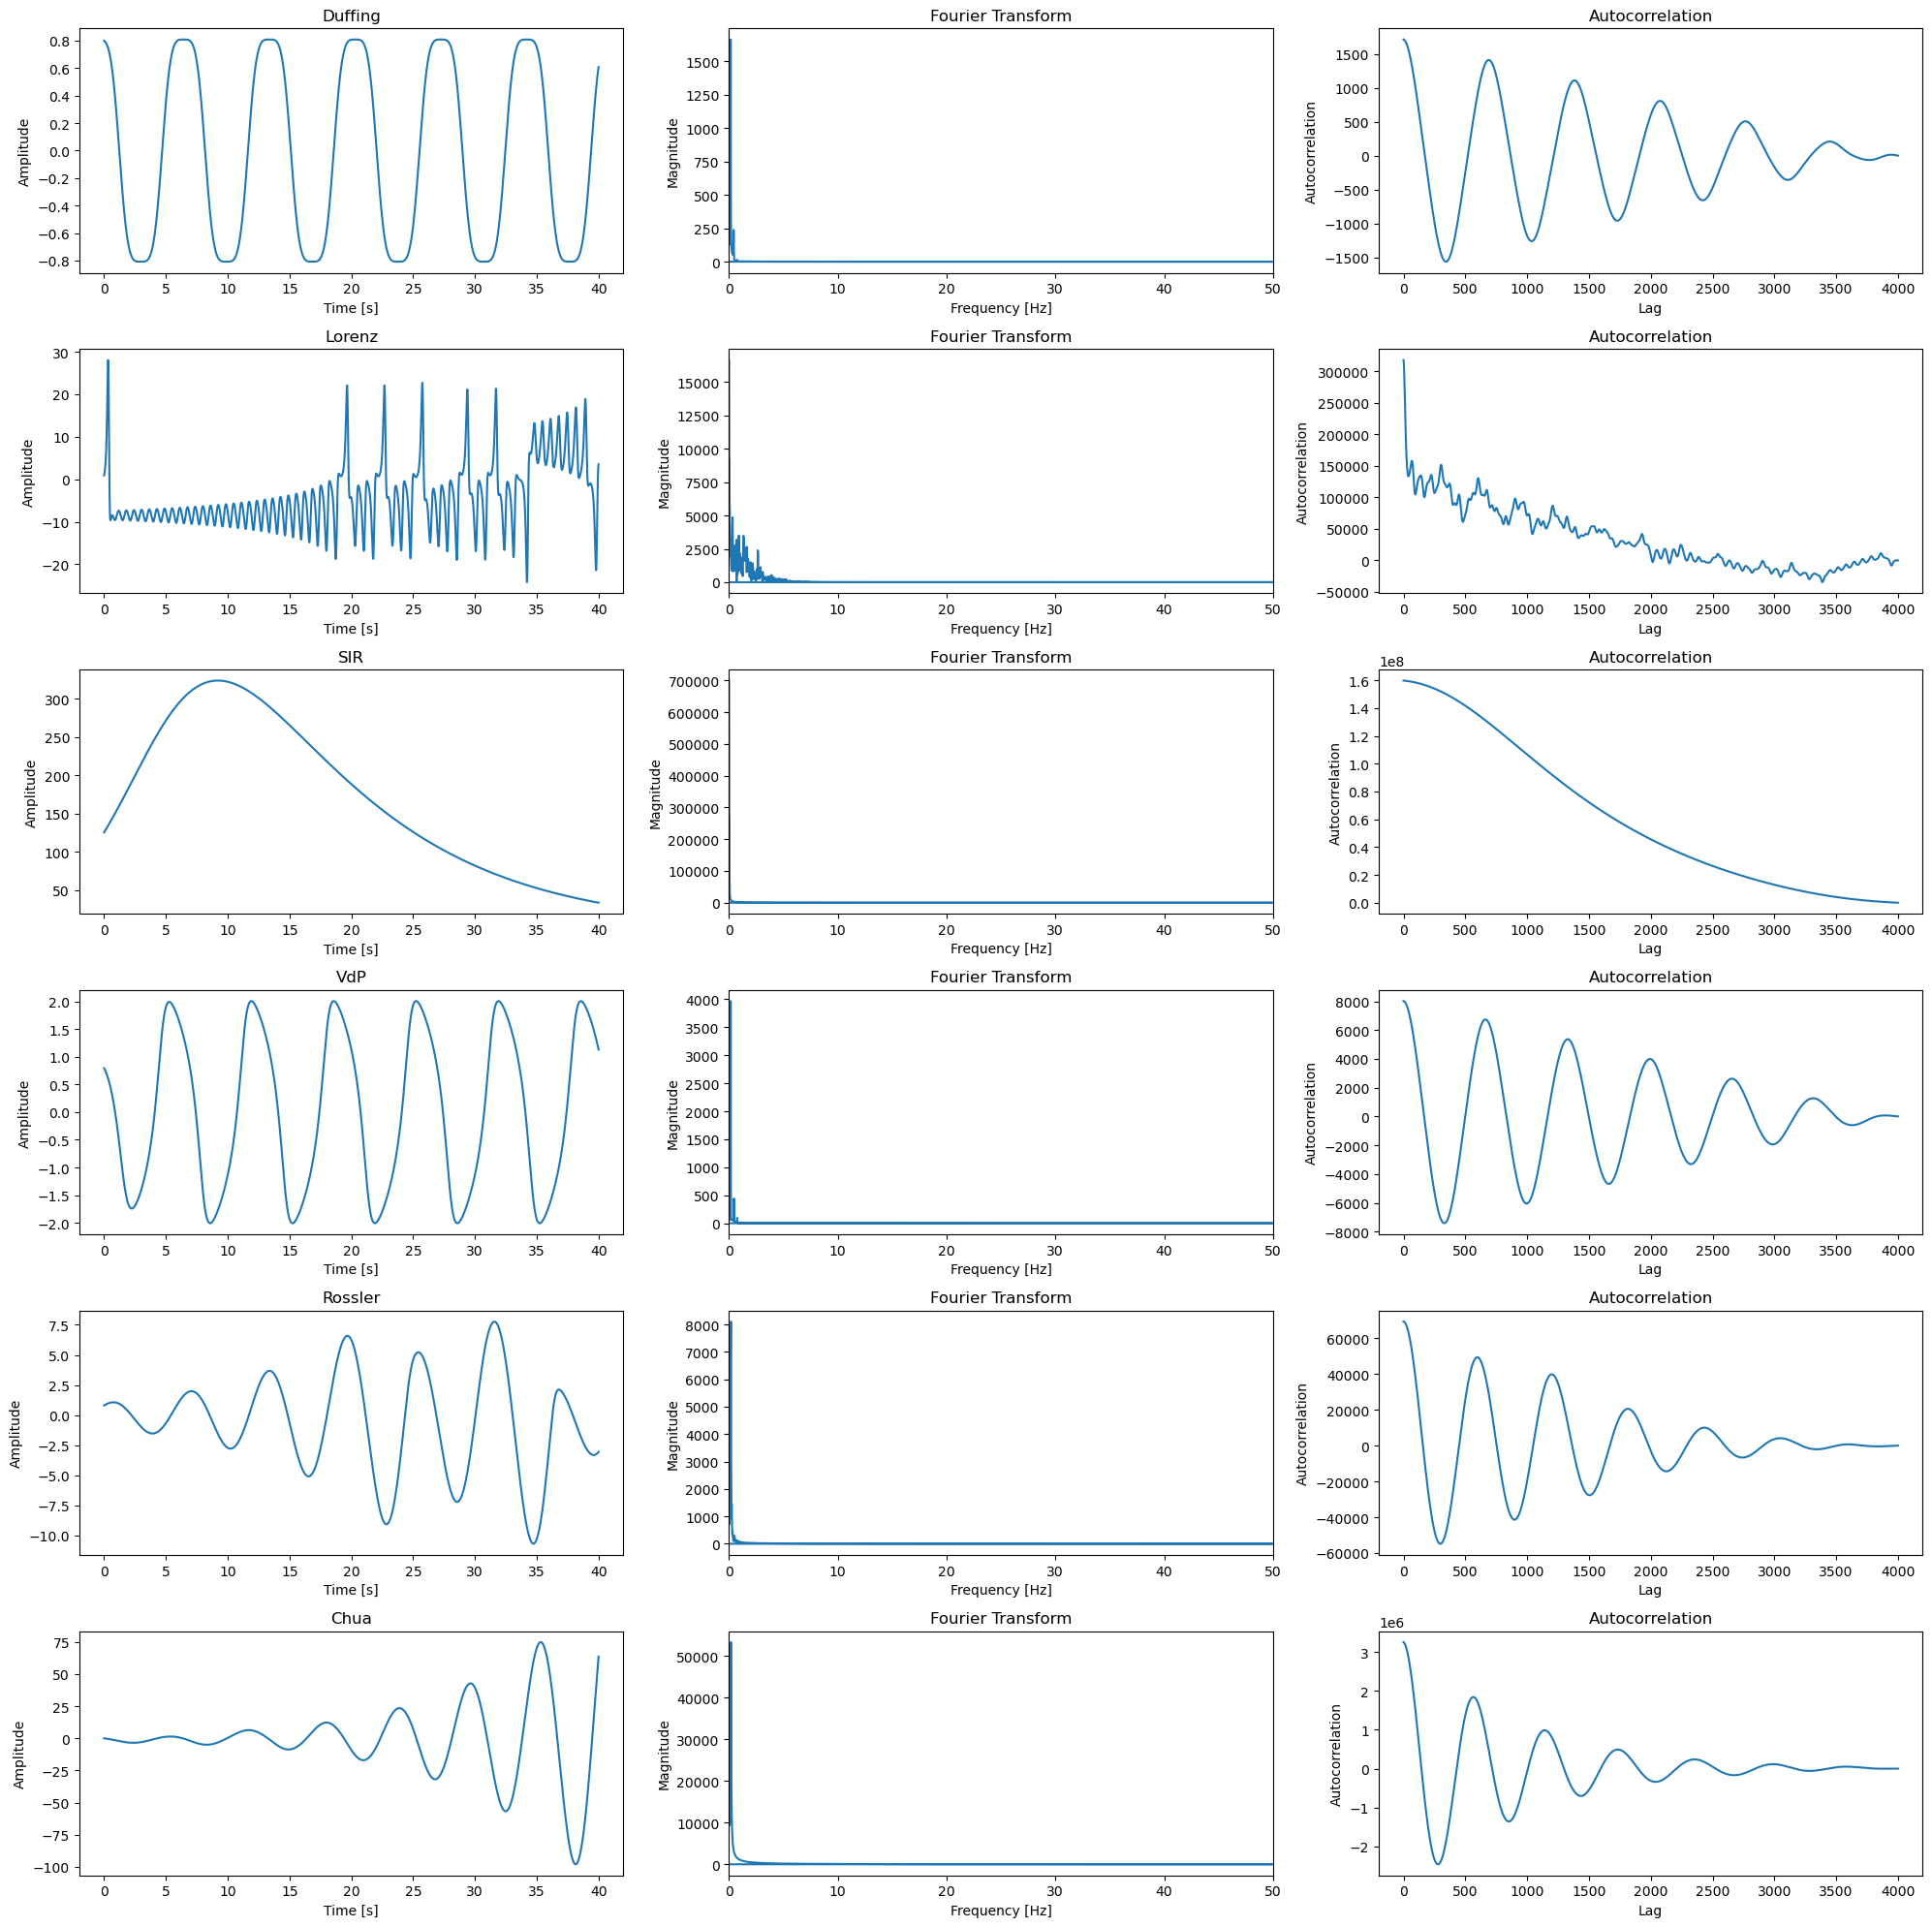

In [41]:
fig, axs = plt.subplots(6, 3, figsize=(20, 20))
idx = 1 # change the initial condition system
ax = axs.flatten()
fs = 1/sim_time.eps
t = np.arange(sim_time.t0, sim_time.tn, sim_time.eps)
for i in range(x.shape[2]):
    signal = x[idx,:,i]
    # Fourier Analysis
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, 1/fs)
    
    # Wavelet Analysis
    wavelet = 'cmor'  # Complex Morlet wavelet
    scales = np.arange(1, 128)
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet, sampling_period=1/fs)

    # Original Signal
    ax[i*3].plot(t, signal)
    ax[i*3].set_title(inp.signal_objects[f'state_{i+1}'].params.signal_data['system'].__class__.__name__)
    ax[i*3].set_xlabel("Time [s]")
    ax[i*3].set_ylabel("Amplitude")
    
    # Fourier Transform
    ax[i*3 + 1].plot(xf, np.abs(yf))
    ax[i*3 + 1].set_title("Fourier Transform")
    ax[i*3 + 1].set_xlabel("Frequency [Hz]")
    ax[i*3 + 1].set_ylabel("Magnitude")
    ax[i*3 + 1].set_xlim(0, 50)
        
    # Autocorrelation
    autocorr = np.correlate(signal, signal, mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    lags = np.arange(0, len(autocorr))
    ax[i*3+2].plot(lags, autocorr)
    ax[i*3+2].set_title("Autocorrelation")
    ax[i*3+2].set_xlabel("Lag")
    ax[i*3+2].set_ylabel("Autocorrelation")
        
plt.tight_layout()
plt.show()

## Complete input visualization

# Dataset visualization

## Opening files

In [ ]:
old_ds_path = '/media/yehias21/DATA/projects/Work/KKL observer/hyperkkl/data/Duffing/reference_dataset.pkl'
with open(old_ds_path, 'rb') as f:
    x_old_data, z_old_data, y_old_data, t_old_data, _ = pk.load(f)


In [ ]:
# print the shape of each attribute
print('x_shapes', x_old_data.shape)
print('z_shapes', z_old_data.shape)
print('y_shapes', y_old_data.shape)
print('t_shapes', t_old_data.shape)


## Visualization of each variable

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(18, 15))
states, states_sim = ['x_states', 'z_states', 'Y_out'], [x_old_data, z_old_data, y_old_data]

for idx, (name, trajs) in enumerate(zip(states, states_sim)):
    ax[idx].set_title(name)
    traj = random.choice(trajs)
    if traj.ndim > 1:  # If trajectory has multiple dimensions
        for dim in range(traj.shape[1]):
            ax[idx].plot(traj[:, dim])
    else:
        ax[idx].plot(traj)

plt.tight_layout()
plt.show()

### Phase plot of the x_States

In [ ]:
plt.figure(figsize=(12, 8))
plt.title("Phase Plot for x_data_old")
traj = random.choice(x_old_data)
plt.plot(traj[:, 0], traj[:, 1], '.')
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

# Visualize New Dataset w/o Input

In [ ]:
path_no_inp = '/media/yehias21/DATA/projects/Work/KKL observer/hyperkkl/data/2024-06-23/18-07-42/train_wo_inp.pth'
with open(path_no_inp, 'rb') as f:
    ds_no_inp = torch.load(f)
ds_no_inp.__dict__.keys()

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(18, 15))
states, states_sim = ['x_states', 'z_states', 'Y_out'], [ds_no_inp.x_states['x_regress'],
                                                         ds_no_inp.z_states['z_regress'], ds_no_inp.y_out['y_regress']]
for idx, (name, trajs) in enumerate(zip(states, states_sim)):
    ax[idx].set_title(name)
    trajs = np.squeeze(trajs)
    print(trajs.shape)
    traj = random.choice(trajs)
    if traj.ndim > 1:  # If trajectory has multiple dimensions
        for dim in range(traj.shape[1]):
            ax[idx].plot(traj[:, dim])
    else:
        ax[idx].plot(traj)

plt.tight_layout()
plt.show()
with rasterio.open(crops_path) as crop_src, rasterio.open(masks_path) as mask_src:
    crops = crop_src.read([7, 5, 3]).astype(np.float32).transpose(1, 2, 0)
    masks = mask_src.read([1, 2, 3]).transpose(1, 2, 0)


In [ ]:
def a7a():
    x = [i for i in range(10)]
    for z in x:
        yield z


for i in a7a():
    print(i)


## State space

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

traj = random.choice(np.squeeze(ds_no_inp.x_states['x_regress']))

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], lw=0.5)

ax.set_title("3D Lorenz Attractor")
ax.set_xlabel("Dimension 1 (x)")
ax.set_ylabel("Dimension 2 (y)")
ax.set_zlabel("Dimension 3 (z)")
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
plt.title("Phase Plot for x_data_old")
traj = random.choice(np.squeeze(ds_no_inp.x_states['x_regress']))
plt.plot(traj[:, 0], traj[:, 1])
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

# Data visualization with input #1 -- EASY INPUT 

In [ ]:
path_w_inp = '//media/yehias21/DATA/projects/Work/KKL observer/hyperkkl/data/2024-05-06/17-02-33/train_inp.pth'
with open(path_w_inp, 'rb') as f:
    ds_inp = torch.load(f)
ds_inp.__dict__.keys()

In [ ]:
# print the shape of each attribute
print('x_shapes', ds_inp.x_states['x_regress'].shape)
print('z_shapes', ds_inp.z_states['z_regress'].shape)
print('y_shapes', ds_inp.y_out['y_regress'].shape)
print('inp_shapes', ds_inp.exo_input.shape)

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(18, 15))
states, states_sim = ['x_states', 'z_states', 'Y_out', 'input'], [ds_inp.x_states['x_regress'],
                                                                  ds_inp.z_states['z_regress'],
                                                                  ds_inp.y_out['y_regress'],
                                                                  ds_inp.exo_input]
for idx, (name, trajs) in enumerate(zip(states, states_sim)):
    ax[idx].set_title(name)
    if trajs.ndim == 4:
        trajs = np.squeeze(trajs)
    print(trajs.shape)
    traj = random.choice(trajs)
    if traj.ndim > 1:  # If trajectory has multiple dimensions
        for dim in range(traj.shape[1]):
            ax[idx].plot(traj[:, dim])
    else:
        ax[idx].plot(traj)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
plt.title("Phase Plot for x_data_old")
traj = random.choice(np.squeeze(ds_inp.x_states['x_regress']))
plt.plot(traj[:, 0], traj[:, 1])
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

# Data visualization with input #2 --HARD INPUT

In [ ]:
path_w_inp = '/media/yehias21/DATA/projects/Work/KKL observer/hyperkkl/data/2024-05-06/22-24-29/train_wo_inp.pth'
with open(path_w_inp, 'rb') as f:
    ds_inp = torch.load(f)
ds_inp.__dict__.keys()

In [ ]:
# print the shape of each attribute
print('x_shapes', ds_inp.x_states['x_regress'].shape)
print('z_shapes', ds_inp.z_states['z_regress'].shape)
print('y_shapes', ds_inp.y_out['y_regress'].shape)
print('inp_shapes', ds_inp.exo_input.shape)

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(18, 15))
states, states_sim = ['x_states', 'z_states', 'Y_out', 'input'], [ds_inp.x_states['x_regress'],
                                                                  ds_inp.z_states['z_regress'],
                                                                  ds_inp.y_out['y_regress'],
                                                                  ds_inp.exo_input]
for idx, (name, trajs) in enumerate(zip(states, states_sim)):
    ax[idx].set_title(name)
    if trajs.ndim == 4:
        trajs = np.squeeze(trajs)
    print(trajs.shape)
    traj = random.choice(trajs)
    if traj.ndim > 1:  # If trajectory has multiple dimensions
        for dim in range(traj.shape[1]):
            ax[idx].plot(traj[:, dim])
    else:
        ax[idx].plot(traj)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
plt.title("Phase Plot for x_data_old")
traj = random.choice(np.squeeze(ds_inp.x_states['x_regress']))
plt.plot(traj[:, 0], traj[:, 1])
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()